In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# !wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/Test.csv -O Test.csv
# !wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/Train.csv -O Train.csv
# !wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/SampleSubmission.csv -O SampleSubmission.csv
# !pip install catboost
# !pip install category_encoders
import catboost
df = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

df.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,560,NaN,2,59,3,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,4510000
1,1,2011-1,667,NaN,10,50,2,1,25.0,NaN,...,0,0,0,0,0,0,0,0,0,13231000
2,2,2011-1,90,0.0,1,48,2,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,2008000
3,3,2011-1,94,1.0,3,62,3,1,30.0,NaN,...,0,0,0,0,0,0,0,0,0,12680000
4,4,2011-1,232,0.0,3,60,3,0,25.0,NaN,...,0,0,0,0,0,0,0,0,0,3335000


In [5]:
df['year'] = pd.DatetimeIndex(df.date).year - 2011
df['month'] = pd.DatetimeIndex(df.date).month
df['mohth_from_begin'] = df.year * 12 + pd.DatetimeIndex(df.date).month
df_test['year'] = pd.DatetimeIndex(df_test.date).year - 2011
df_test['month'] = pd.DatetimeIndex(df_test.date).month
df_test['mohth_from_begin'] = df_test.year * 12 + pd.DatetimeIndex(df_test.date).month

del df['date']
del df_test['date']
df = df.iloc[df.price.values != 1000000, :]  # удаляю вброс


df['price_m2'] = df.price / df.area
df.reset_index(inplace=True)
del df['index']
del df['id']
df.shape

(95921, 27)

In [6]:
# df[df.year.values == 1].groupby('month').mean().price.plot()  # цикличности вроде нет
# df[df.year.values == 0].groupby('month').mean().price.plot()  
del df['month']

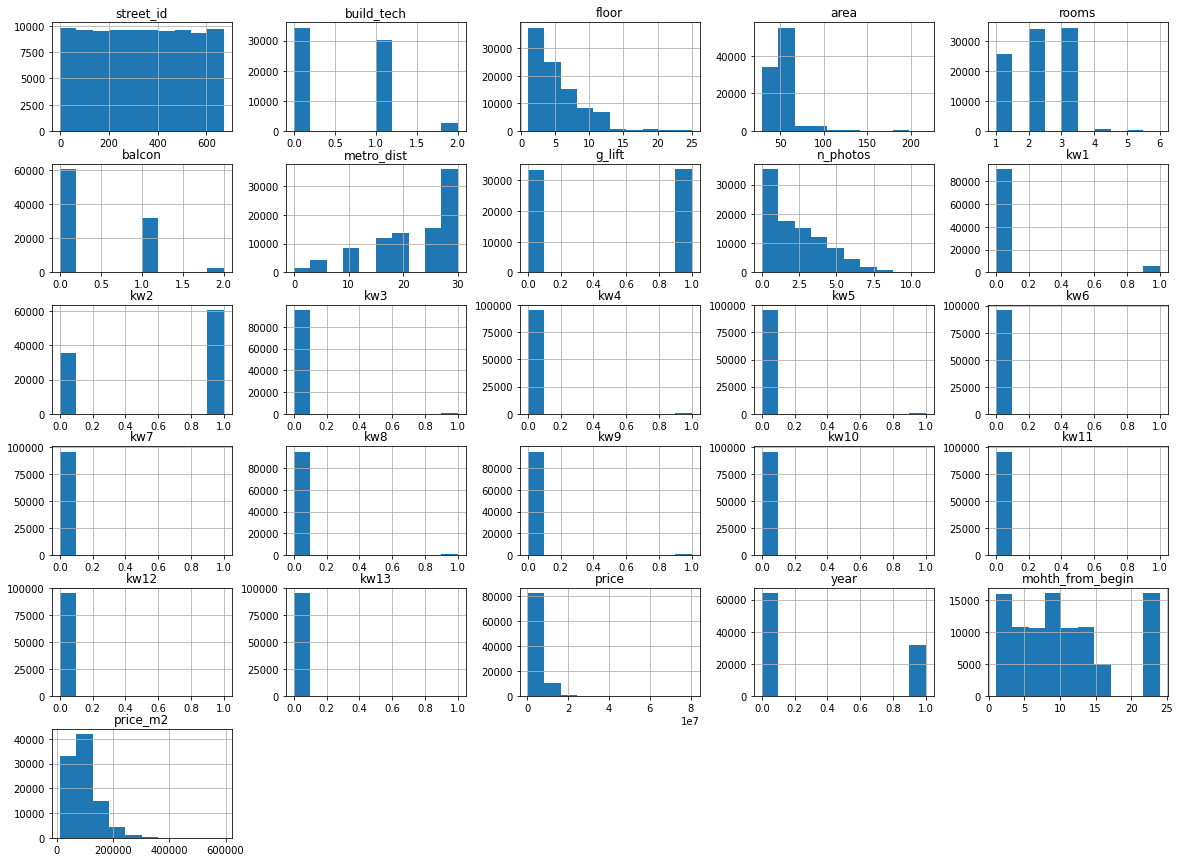

In [7]:
df.hist(figsize=(20, 15))
None

Тренировочная выборка mohth_from_begin<= 15, валидационная >15

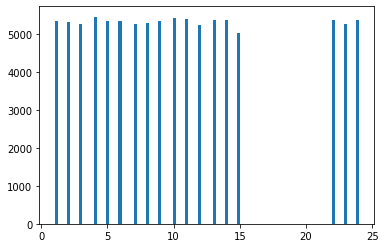

In [8]:
plt.hist(df.mohth_from_begin.values, bins=100)

Проверяю связь признака с ценой

In [9]:
# check = df[{'price', 'build_tech'}].groupby('build_tech').mean()  # можно рассматривать как числовой признак
# check = df[{'price', 'street_id'}].groupby('street_id').mean()  # категориальный
# check = df[{'price', 'floor'}].groupby('floor').mean()  # числовой 
# check = df[{'price', 'balcon'}].groupby('balcon').mean()  # можно рассматривать как числовой признак
# check = df[{'price', 'metro_dist'}].groupby('metro_dist').mean()  # числовой
# check = df[{'price', 'g_lift'}].groupby(['g_lift']).mean()  # бесполезный на первый взгляд
# check = df[{'price', 'street_id', 'g_lift'}].groupby(['street_id', 'g_lift']).mean()  # а так очень даже ничего - числовой
# check = df[{'price', 'n_photos'}].groupby('n_photos').mean()  # числовой
# check = df[{'price', 'kw1'}].groupby('kw1').mean()  # числовой
# check = df[{'price', 'kw2'}].groupby('kw2').mean()  # числовой
# check = df[{'price', 'kw3'}].groupby('kw3').mean()  # числовой
# check = df[{'price', 'kw4'}].groupby('kw4').mean()  # числовой
# check = df[{'price', 'kw5'}].groupby('kw5').mean()  # числовой
# check = df[{'price', 'kw6'}].groupby('kw6').mean()  # числовой
# check = df[{'price', 'kw7'}].groupby('kw7').mean()  # числовой
# check = df[{'price', 'kw8'}].groupby('kw8').mean()  # числовой  # не вижу информативности, при том, что сильно несбалансированы - выкидываю
# check = df[{'price', 'kw9'}].groupby('kw9').mean()  # числовой  #не вижу информативност, что сильно несбалансированы - выкидываю
# check = df[{'price', 'kw10'}].groupby('kw10').mean()  # числовой
# check = df[{'price', 'kw11'}].groupby('kw11').mean()  # числовой
# check = df[{'price', 'kw12'}].groupby('kw12').mean()  # числовой
check = df[{'price', 'kw13'}].groupby('kw13').mean()  # числовой
check

,price
kw13,
0,5.312327e+06
1,1.515520e+07


In [10]:
del (df['kw8'])
del (df['kw9'])
del (df_test['kw8'])
del (df_test['kw9'])
del (df_test['g_lift'])
# del (df['g_lift'])

Пропуски: build_tech, metro_dist, g_lift Проверяю с чем это связано. Так же проставляю веса наблюдениями. По принципу, есть пропуск - вес меньше. В конце все же выяснилось, что g_lift мусорный признак. Его удаляю.

Считаю веса наблюдений. Редкие более ценны чем частые

In [11]:
df['weights_unique'] = 0
counts = df.price.value_counts().values
values = df.price.value_counts().index.values
for i in range(values.shape[0]):
    df.weights_unique[df.price.values == values[i]] = 1 / np.cbrt(counts[i])  # веса наблюдений

In [12]:
df['weights_miss'] = 1
df.fillna(value=-9999, inplace=True)
df.weights_miss[df.metro_dist.values == -9999] = df.weights_miss[df.metro_dist.values == -9999] * 0.7 # предсказывается средне
df.weights_miss[df.build_tech.values == -9999] = df.weights_miss[df.build_tech.values == -9999] * 0.8  # предсказывается хорошо
df['weights'] = df.weights_unique * df.weights_miss
df_test.fillna(value=-9999, inplace=True)


In [13]:
# check = df.groupby('build_tech').mean()  # скорее всего просто разбросаны. Имеет смысл заполнять моделью
# check = df.groupby(['g_lift']).mean() # скорее всего просто разбросаны. Имеет смысл заполнять моделью
# check = df[{'street_id', 'g_lift', 'price'}].groupby(['street_id', 'g_lift']).mean() 
# check = df.groupby(['g_lift']).mean()
check = df[{'metro_dist', 'price'}].groupby(['metro_dist']).mean() # скорее всего просто разбросаны. Имеет смысл заполнять моделью 
check.head(20)

,price
metro_dist,
-9999.0,5.283112e+06
0.0,6.044868e+06
5.0,5.926236e+06
10.0,5.915242e+06
15.0,5.774506e+06
20.0,5.584376e+06
25.0,5.165248e+06
30.0,4.880374e+06


Заполняю build_tech

In [17]:
from catboost import CatBoostClassifier 
from catboost import Pool

df_train = df[(df.mohth_from_begin.values < 20) * (df.build_tech.values != -9999)]
df_valid = df[(df.mohth_from_begin.values > 20) * (df.build_tech.values != -9999)]

features = ['street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos',
            'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']


train_pool = Pool(data=df_train[features], label=df_train.build_tech.values, cat_features=cat_features, weight = df_train.weights.values)
valid_pool = Pool(df_valid[features], label=df_valid.build_tech.values, cat_features=cat_features)
build_model = CatBoostClassifier(random_state=42)
build_model.fit(train_pool, eval_set=valid_pool, verbose = False)
pred_train = build_model.predict(df_train[features])
pred_valid = build_model.predict(df_valid[features])

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [18]:
from sklearn.metrics import classification_report
print("train: \n", classification_report(pred_train, df_train.build_tech.values))
print("valid: \n", classification_report(pred_valid, df_valid.build_tech.values))

train: 
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     29715
         1.0       0.92      0.96      0.94     24100
         2.0       0.96      0.97      0.97      2238

    accuracy                           0.95     56053
   macro avg       0.95      0.95      0.95     56053
weighted avg       0.95      0.95      0.95     56053

valid: 
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.94      6030
         1.0       0.91      0.95      0.93      4846
         2.0       0.95      0.96      0.96       456

    accuracy                           0.94     11332
   macro avg       0.94      0.95      0.94     11332
weighted avg       0.94      0.94      0.94     11332



In [19]:
df.build_tech[df.build_tech.values == -9999] = build_model.predict(df[df.build_tech.values == -9999][features].values).reshape(-1)
df_test.build_tech[df_test.build_tech == -9999] = build_model.predict(df_test[df_test.build_tech.values == -9999][features].values).reshape(-1)

In [20]:
from catboost import CatBoostRegressor

df_train = df[(df.mohth_from_begin.values < 20) * (df.metro_dist.values != -9999)]
df_valid = df[(df.mohth_from_begin.values > 20) * (df.metro_dist.values != -9999)]

features = ['build_tech', 'street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos',
            'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']

train_pool = Pool(data=df_train[features], label=df_train.metro_dist, cat_features=cat_features, weight = df_train.weights.values)
valid_pool = Pool(data=df_valid[features], label=df_valid.metro_dist, cat_features=cat_features)
metro_model = CatBoostRegressor(loss_function = 'MAE', eval_metric='MAE', 
                random_state=42, n_estimators=3000,
)
metro_model.fit(train_pool, eval_set=valid_pool, verbose = False)
pred_train = metro_model.predict(df_train[features])
pred_valid = metro_model.predict(df_valid[features])

In [21]:
from sklearn.metrics import mean_absolute_error
print("train: \n", mean_absolute_error(pred_train, df_train.metro_dist.values))
print("valid: \n", mean_absolute_error(pred_valid, df_valid.metro_dist.values))

train: 
 5.038040346385407
valid: 
 5.204905966021991


In [22]:
df.metro_dist[df.metro_dist.values == -9999] = metro_model.predict(df[df.metro_dist.values == -9999][features])
df_test.metro_dist[df_test.metro_dist == -9999] = metro_model.predict(df_test[df_test.metro_dist.values == -9999][features])

In [23]:
# округляю
df.metro_dist = round(df.metro_dist / 5) * 5  
df_test.metro_dist = round(df_test.metro_dist / 5) * 5

Анализирую стомость квартир в каждом месяце. Делаю преобразование Бокса-Кокса. Получаю распределения очень похожие на нормальные. Удобно отслеживать пороговые значения -3, 3 стандартных отклонений, на предмет выбросов.

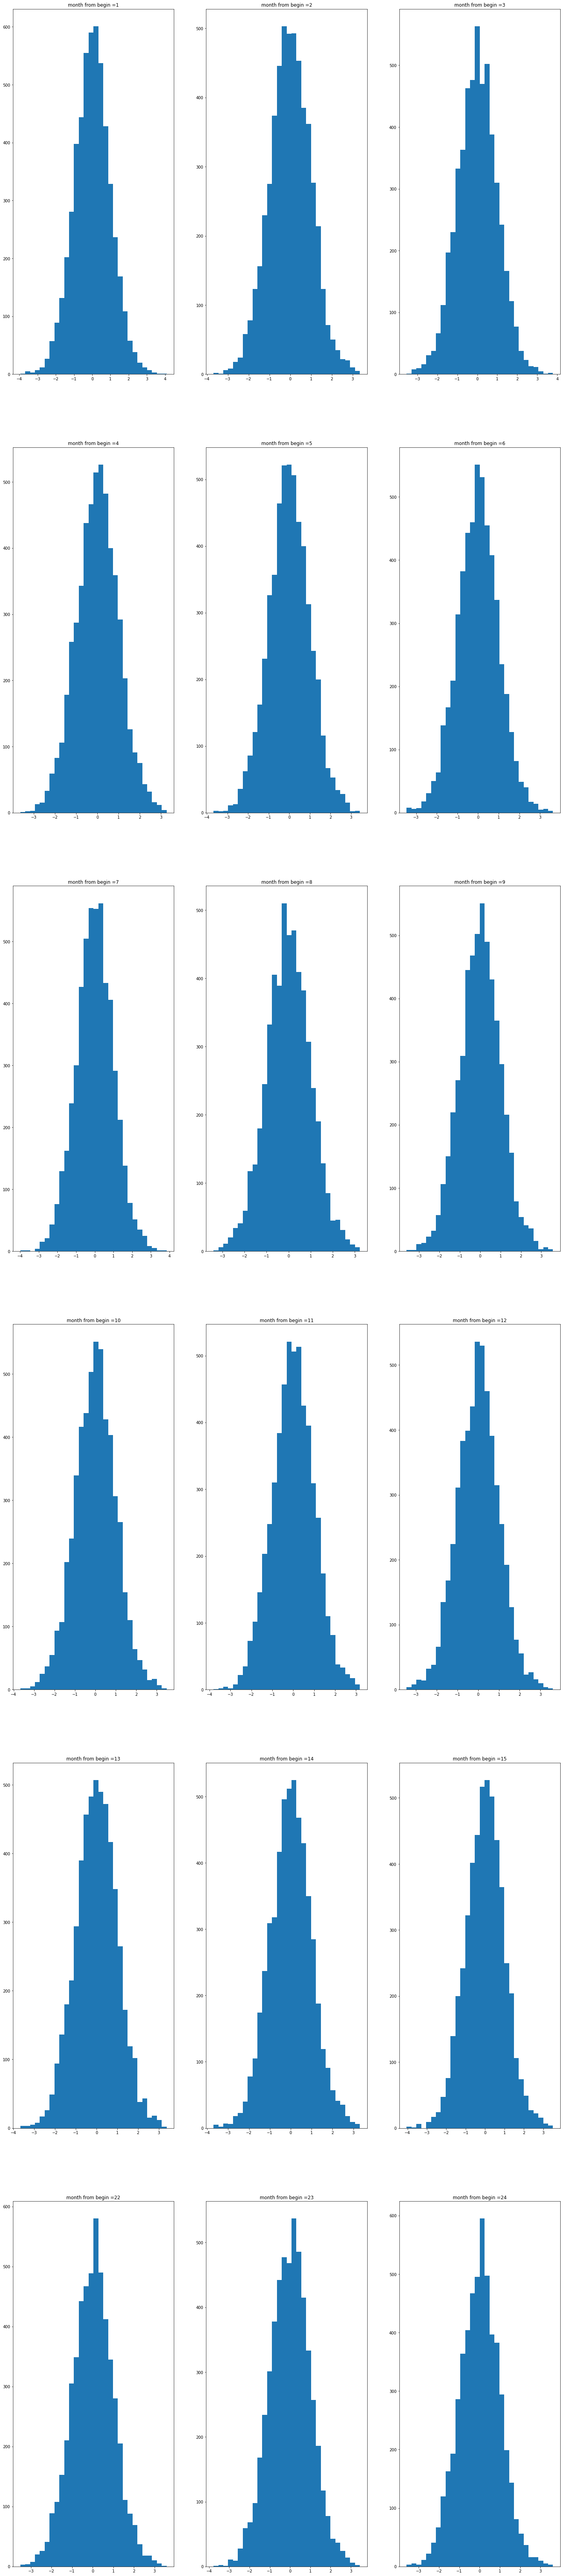

In [24]:
from sklearn.preprocessing import PowerTransformer
spisok = []
y = df.mohth_from_begin.values
df['normal_price_month'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price[y == i].values.reshape(-1, 1))
    df.normal_price_month[y == i] = PW.transform(df.price[y == i].values.reshape(-1, 1)).reshape(-1)
    spisok.append(PW)
    
fig, ax = plt.subplots(6, 3, figsize=(25,120))
n, k, i = 0, 0, 0
for i, month in enumerate(np.unique(y)):
    ax[i // 3, i % 3].hist(df.normal_price_month[y == month].values, bins = 30)
    ax[i // 3, i % 3].set_title('month from begin =' + str(month))

Стоймость квартир в зависимости от улицы

In [25]:
street_spisok = []
y = df.street_id.values
df['normal_price_street'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price[y == i].values.reshape(-1, 1))
    df.normal_price_street[y == i] = PW.transform(df.price[y == i].values.reshape(-1, 1)).reshape(-1)
    street_spisok.append(PW)

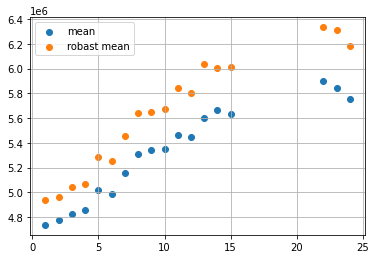

In [26]:
mean_price = df[['price', 'mohth_from_begin']].groupby(['mohth_from_begin']).mean()  # просто средня цена


df['weight_price'] = df.price * df.weights  # вклад в стоймость, нет пропусков и уникальное значение стоймости - большой вклад
mask1 = (df['normal_price_month'].values < 2) * (df['normal_price_month'].values > -2) # выбираю только квартиры с ценами в пределах -2 2 стандартных отклонений по месяцам
mask2 = (df['normal_price_street'].values < 3) * (df['normal_price_street'].values > -3) # выбираю только квартиры с ценами в пределах -3 3 стандартных отклонений по улицам 
mask = mask1 * mask2
robast_mean_price = df[['weight_price', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum() / df[['weights', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum().values
plt.scatter(mean_price.index, mean_price.values, label = "mean")
plt.scatter(robast_mean_price.index, robast_mean_price.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

В старых данных был экспонециальный рост!!!

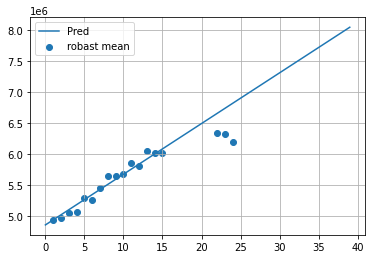

In [27]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

train = robast_mean_price[:15]
linear_model = SVR(kernel = 'poly', degree= 1, C = 1e5).fit(X = train.index.values.reshape(-1, 1), y = train.values)
pred = linear_model.predict(X = np.arange(0, 40).reshape(-1, 1))

plt.plot(np.arange(0, 40).reshape(-1, 1), pred, label = "Pred")
plt.scatter(robast_mean_price.index, robast_mean_price.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

Вычисляю коэффицент стоймости от месяца по модели

In [28]:
time_0 = linear_model.predict([[0]])
df['pred_mean'] = linear_model.predict(df.mohth_from_begin.values.reshape(-1, 1))  # прогноз средней цены
df['model_time_coef'] = df.pred_mean / time_0  # коэффициент стоймости от времени
df['model_price_without_time'] = df.price / df.model_time_coef  # цена с поправкой на время
df_test['model_pred_mean'] = linear_model.predict(df_test.mohth_from_begin.values.reshape(-1, 1))  # прогноз средней цены для теста
df_test['model_time_coef'] = df_test.model_pred_mean / time_0

Вычисляю коэффицент стоймости от месяца, как отношение рабастных оценок стоймости

In [29]:
df['time_coef'] = 0
for i in df.mohth_from_begin.unique():
    df.time_coef[df.mohth_from_begin.values == i] = robast_mean_price.loc[i].values / robast_mean_price.loc[1].values
df['price_without_time'] = df.price / df.time_coef

Стоймость квадратного метра в зависимости от даты и улицы

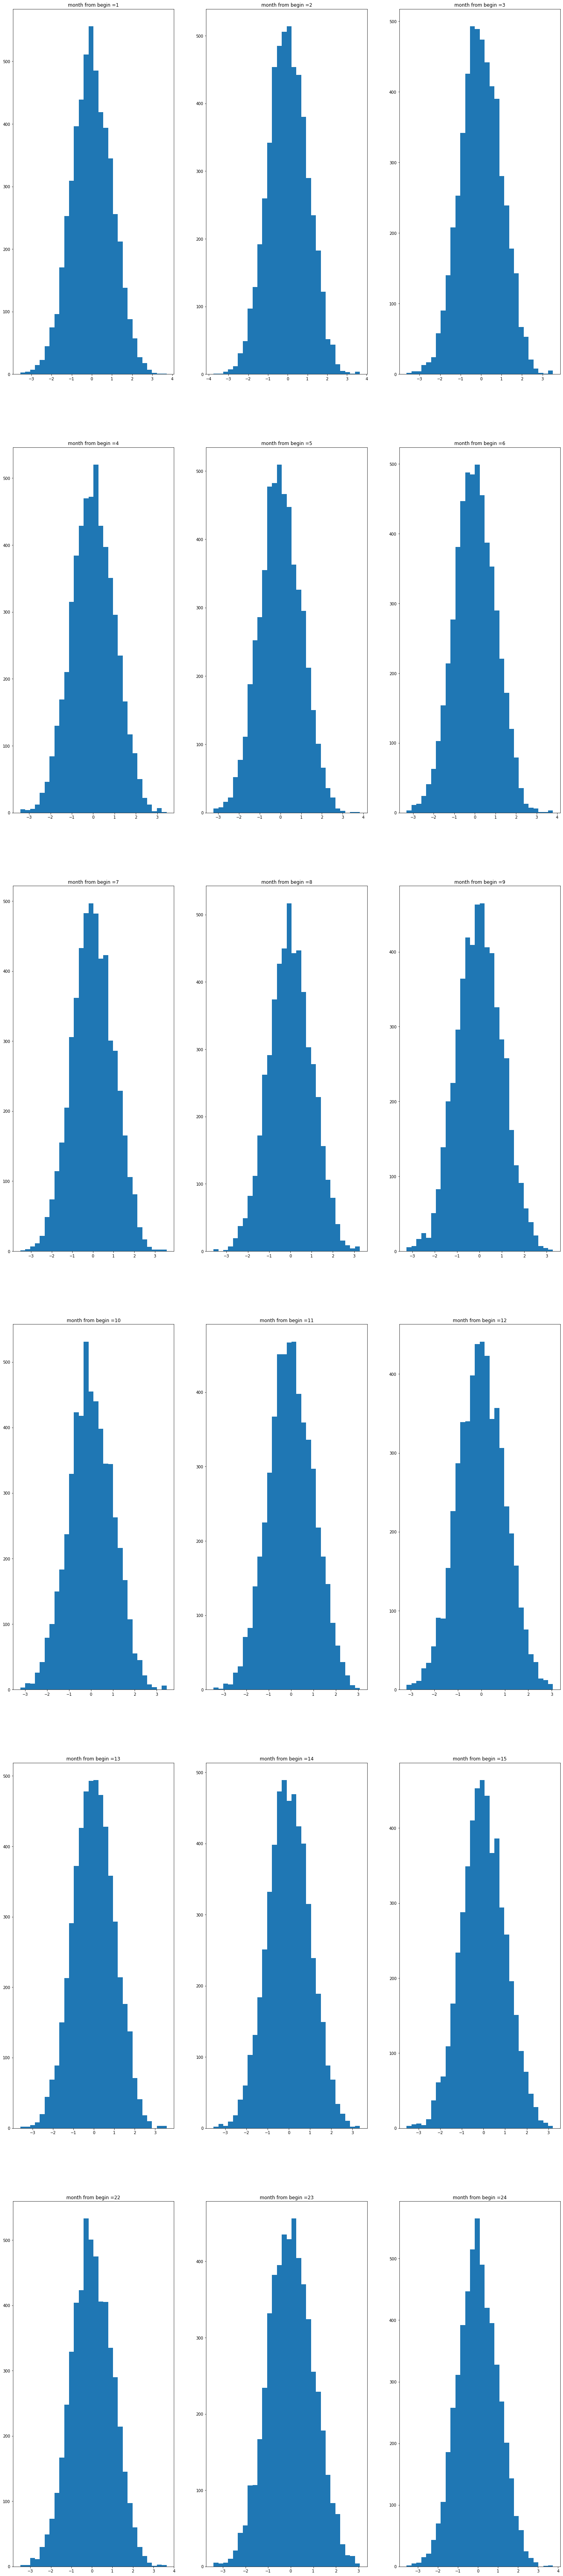

In [30]:
spisok = []
y = df.mohth_from_begin.values
df['normal_price_month_m2'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price_m2[y == i].values.reshape(-1, 1))
    df.normal_price_month_m2[y == i] = PW.transform(df.price_m2[y == i].values.reshape(-1, 1)).reshape(-1)
    spisok.append(PW)
    
fig, ax = plt.subplots(6, 3, figsize=(25,120))
n, k, i = 0, 0, 0
for i, month in enumerate(np.unique(y)):
    ax[i // 3, i % 3].hist(df.normal_price_month_m2[y == month].values, bins = 30)
    ax[i // 3, i % 3].set_title('month from begin =' + str(month))

In [31]:
street_spisok = []
y = df.street_id.values
df['normal_price_street_m2'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price_m2[y == i].values.reshape(-1, 1))
    df.normal_price_street_m2[y == i] = PW.transform(df.price_m2[y == i].values.reshape(-1, 1)).reshape(-1)
    street_spisok.append(PW)


In [32]:
df[df.normal_price_street_m2.values > 3]

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,normal_price_month,normal_price_street,weight_price,pred_mean,model_time_coef,model_price_without_time,time_coef,price_without_time,normal_price_month_m2,normal_price_street_m2
10917,73,1.0,11,67,2,0,30.0,1.0,1,0,...,1.106728,1.698435,4.468184e+06,5.753695e+06,1.184955,7.482140e+06,1.184068,7.487745e+06,0.811540,3.106377
54068,241,1.0,2,33,1,1,15.0,1.0,0,1,...,0.273403,0.846671,1.652351e+06,5.508766e+06,1.134513,4.387787e+06,1.142833,4.355841e+06,1.123889,3.024224
70501,428,1.0,8,110,3,0,25.0,0.0,6,1,...,1.854132,2.656622,1.635200e+07,6.651767e+06,1.369910,1.193655e+07,1.282838,1.274674e+07,0.903199,3.131537
71727,356,1.0,6,51,2,1,15.0,-9999.0,3,0,...,0.778105,1.830988,4.814788e+06,6.651767e+06,1.369910,5.579198e+06,1.282838,5.957883e+06,0.919442,3.091376
73002,221,1.0,4,51,2,1,25.0,0.0,2,0,...,1.273525,2.227252,5.951258e+06,6.651767e+06,1.369910,7.831900e+06,1.282838,8.363487e+06,1.597812,3.098311
74401,600,2.0,6,67,2,2,20.0,1.0,2,0,...,0.960539,2.246204,4.321000e+06,6.651767e+06,1.369910,6.308443e+06,1.282838,6.736625e+06,0.618007,3.443364
77398,557,1.0,7,62,2,1,30.0,0.0,1,0,...,2.123652,2.671982,1.940000e+07,6.733410e+06,1.386724,1.398980e+07,1.278990,1.516822e+07,2.404213,3.484315
77832,117,1.0,5,50,2,0,0.0,-9999.0,1,0,...,1.022131,1.955989,6.217371e+06,6.733410e+06,1.386724,6.466318e+06,1.278990,7.011000e+06,1.291019,3.064218
79000,25,1.0,2,34,1,0,0.0,0.0,0,0,...,-0.165560,0.540398,1.835829e+06,6.733410e+06,1.386724,3.030884e+06,1.278990,3.286186e+06,0.537755,3.014275
80999,643,1.0,11,35,1,1,20.0,1.0,0,0,...,-0.485106,0.606900,1.478309e+06,6.815053e+06,1.403538,2.476598e+06,1.252724,2.774752e+06,0.094092,3.279015


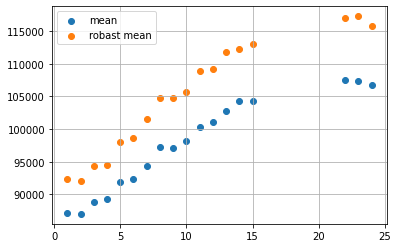

In [33]:
mean_price_m2 = df[['price_m2', 'mohth_from_begin']].groupby(['mohth_from_begin']).mean()  # просто средня цена


df['weight_price_m2'] = df.price_m2 * df.weights  # вклад в стоймость, нет пропусков и уникальное значение стоймости - большой вклад
mask1 = (df['normal_price_month'].values < 2) * (df['normal_price_month'].values > -2) # выбираю только квартиры с ценами в пределах -1 1 стандартных отклонений по месяцам
mask2 = (df['normal_price_street'].values < 3) * (df['normal_price_street'].values > -3) # выбираю только квартиры с ценами в пределах -2 2 стандартных отклонений по улицам (здесь 2 тк их выборка для каждого меньше)
mask = mask1 * mask2
robast_mean_price_m2 = df[['weight_price_m2', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum() / df[['weights', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum().values
plt.scatter(mean_price_m2.index, mean_price_m2.values, label = "mean")
plt.scatter(robast_mean_price_m2.index, robast_mean_price_m2.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

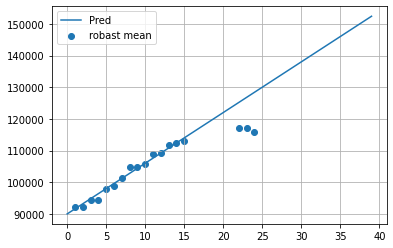

In [34]:
train = robast_mean_price_m2[:15]
linear_model = SVR(kernel = 'poly', degree = 1,  C = 10000).fit(X = train.index.values.reshape(-1, 1), y = train.values)

pred = linear_model.predict(X = np.arange(0, 40).reshape(-1, 1))

plt.plot(np.arange(0, 40).reshape(-1, 1), pred, label = "Pred")
plt.scatter(robast_mean_price_m2.index, robast_mean_price_m2.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

In [35]:
time_0 = linear_model.predict([[0]])
df['model_pred_mean_m2'] = linear_model.predict(df.mohth_from_begin.values.reshape(-1, 1))
df_test['model_pred_mean_m2'] = linear_model.predict(df_test.mohth_from_begin.values.reshape(-1, 1))
df['model_coef_price_m2'] = df['price_m2'] / df['model_pred_mean_m2'] # во сколько квартира лучше средней
df['model_time_coef_m2'] = df.model_pred_mean_m2 / time_0
df['model_price_m2_without_time'] = df.price_m2 / df.model_time_coef_m2


In [36]:
df['time_coef_m2'] = 0
for i in df.mohth_from_begin.unique():
    df.time_coef_m2[df.mohth_from_begin.values == i] = robast_mean_price_m2.loc[i].values / robast_mean_price_m2.loc[1].values
df['price_m2_without_time'] = df.price_m2 / df.time_coef_m2

Выполняю кластеризацию. По площади и стоймости квадратного метра с поправкой на время

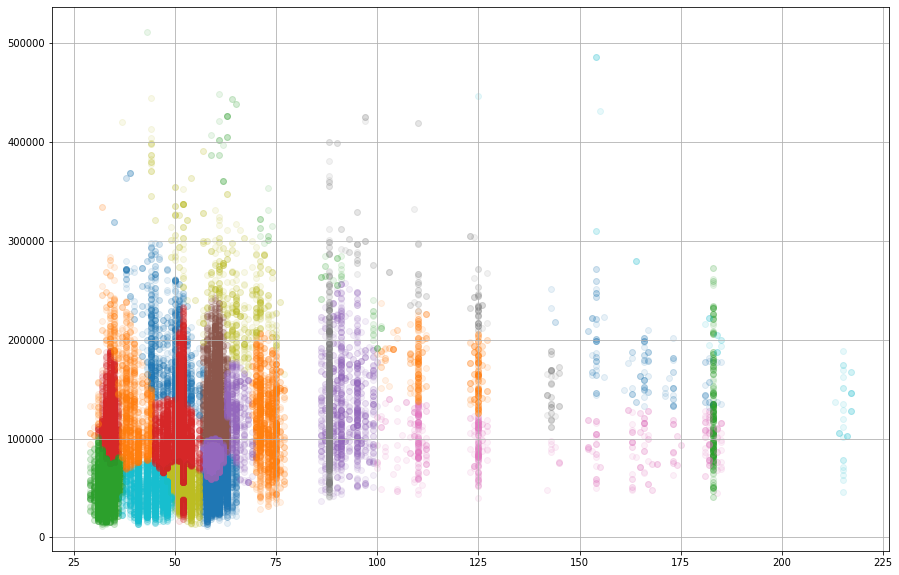

In [37]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())  # список цветов

means_init = []

df_train = df[(df.mohth_from_begin.values < 20) * (df.build_tech.values != -9999)]
train = df_train.sample(frac = 0.6, replace = True, random_state = 42, weights = df_train.weights)

claster = ['model_price_m2_without_time', 'area']
claster = ['model_price_without_time', 'area']
classtering = Pipeline([
    ('SS', StandardScaler()),
    ('GaussianMixture', GaussianMixture(n_components = 25, random_state = 42, n_init = 10)) 
])

labels = classtering.fit_predict(train[claster])


plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(labels):
    plt.scatter(train.area[i == labels].values, train.model_price_m2_without_time[i==labels].values, cmap=colors_list[i], alpha=0.1)
plt.show()

In [38]:
df_train['labels'] = classtering.predict(df_train[claster])

Предсказываю метку кластера по известным признакам

In [39]:
train, valid = train_test_split(df_train, train_size=0.7)
features = ['street_id', 'build_tech', 'floor', 'g_lift', 'area', 'rooms', 'balcon', 'metro_dist', 'n_photos', 
           'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']

target = ['labels']

train_pool = Pool(train[features], label=train[target], weight = train.weights.values)
valid_pool  =Pool(valid[features], label=valid[target])

model = CatBoostClassifier(n_estimators=2000, random_state=42,
                           auto_class_weights='SqrtBalanced'
                    
)
model.fit(train_pool, eval_set=valid_pool, verbose = False)

In [40]:
pred_train = model.predict(train_pool)
pred_valid = model.predict(valid_pool)

In [41]:
train['pred_labels'] = pred_train
valid['pred_labels'] = pred_valid

In [42]:
from sklearn.metrics import classification_report
print("train: \n", classification_report(pred_train, train.labels.values))
print("valid: \n", classification_report(pred_valid, valid.labels.values))

train: 
               precision    recall  f1-score   support

           0       0.74      0.78      0.76      6350
           1       1.00      1.00      1.00      1454
           2       1.00      1.00      1.00       162
           3       0.77      0.74      0.76      4578
           4       1.00      1.00      1.00       743
           5       0.64      0.69      0.67      3083
           6       0.99      1.00      1.00       287
           7       1.00      1.00      1.00        92
           8       0.69      0.85      0.76      4311
           9       1.00      1.00      1.00        25
          10       0.86      0.79      0.82       927
          11       1.00      0.99      1.00       202
          12       0.85      0.86      0.86      7910
          13       0.94      0.84      0.89      6454
          14       0.70      0.67      0.68      5891
          15       0.84      0.67      0.74      1554
          16       1.00      1.00      1.00       117
          17      

Так выглядят истинные метки

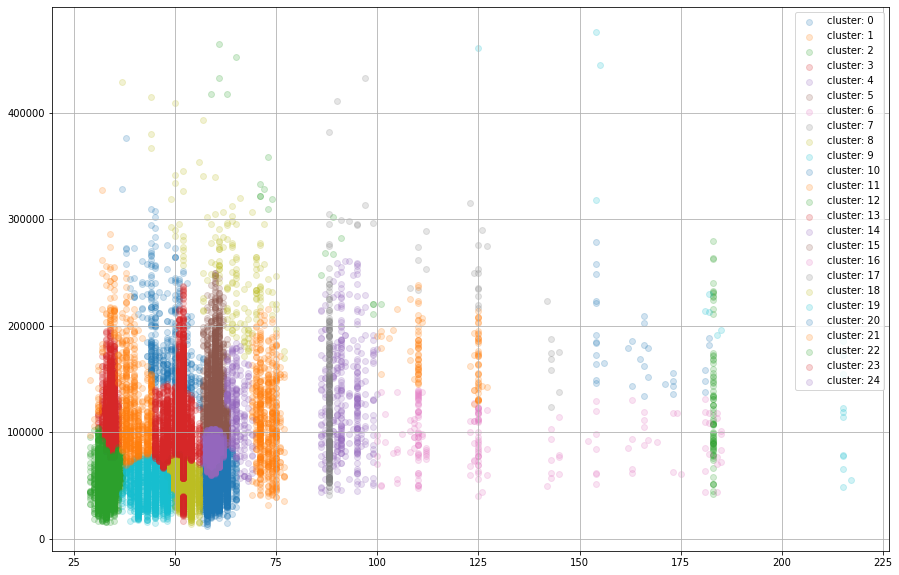

In [43]:
plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(train.pred_labels.unique()):
    plt.scatter(valid.area[i == valid.labels].values, valid.price_m2_without_time[i==valid.labels].values,
                cmap=colors_list[i], alpha=0.2, label ='cluster: ' + str(i))
plt.legend()
plt.show()

А так прогнозные

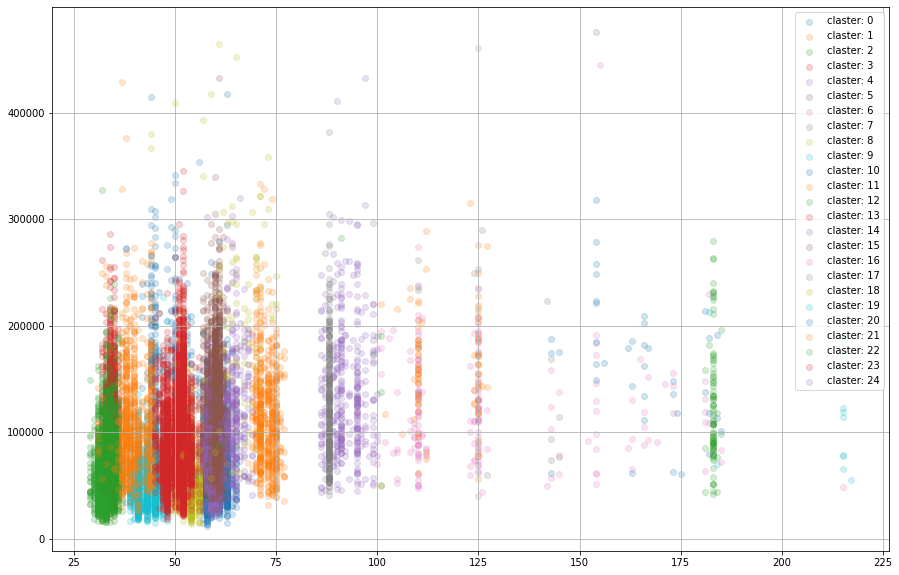

In [44]:
plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(valid.pred_labels.unique()):
    plt.scatter(valid.area[i == valid.pred_labels].values, valid.price_m2_without_time[i==valid.pred_labels].values,
                cmap=colors_list[i], alpha=0.2, label ='claster: ' + str(i))
plt.legend()
plt.show()

In [45]:
df['labels'] = model.predict(df[features])
# df_test['labels'] = model.predict(df_test[features])

In [46]:
mask1 = (df['normal_price_month'].values < 2) * (df['normal_price_month'].values > -2) # выбираю только квартиры с ценами в пределах -2 2 стандартных отклонений по месяцам
mask2 = (df['normal_price_street'].values < 3) * (df['normal_price_street'].values > -3) # выбираю только квартиры с ценами в пределах -3 3 стандартных отклонений по улицам 


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95921 entries, 0 to 95920
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   street_id                    95921 non-null  int64  
 1   build_tech                   95921 non-null  float64
 2   floor                        95921 non-null  int64  
 3   area                         95921 non-null  int64  
 4   rooms                        95921 non-null  int64  
 5   balcon                       95921 non-null  int64  
 6   metro_dist                   95921 non-null  float64
 7   g_lift                       95921 non-null  float64
 8   n_photos                     95921 non-null  int64  
 9   kw1                          95921 non-null  int64  
 10  kw2                          95921 non-null  int64  
 11  kw3                          95921 non-null  int64  
 12  kw4                          95921 non-null  int64  
 13  kw5             

In [48]:
df_train = df[df['mohth_from_begin'].values < 20]
df_valid = df[df['mohth_from_begin'].values > 20]

mask1_train =  (df_train['normal_price_month_m2'].values < 3) * (df_train['normal_price_month_m2'].values > -3)
mask2_train = (df_train['normal_price_street_m2'].values < 3) * (df_train['normal_price_street_m2'].values > -3)
mask_train = mask1_train * mask2_train
mask1_valid =  (df_valid['normal_price_month_m2'].values < 3) * (df_valid['normal_price_month_m2'].values > -3)
mask2_valid = (df_valid['normal_price_street_m2'].values < 3) * (df_valid['normal_price_street_m2'].values > -3)
mask_valid = mask1_valid * mask2_valid




labels = ['labels'] 

initial_features = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'n_photos', 'kw1', 'kw2',
                    'kw3', 'kw4',
         #   'kw5', 'kw6', 'kw7', 'kw10', 'kw11', 'kw12', 'kw13'
                   ]


cat_features_ = ['street_id']

target = ['model_price_without_time']

cat_features = cat_features_ + labels

features = initial_features + labels


train_pool = Pool(data = df_train[features][mask_train], label = df_train[target][mask_train], cat_features=cat_features
#                  , weight=df_train.weights
                  )
valid_pool = Pool(data =df_valid[features][mask_valid], label = df_valid[target][mask_valid], cat_features=cat_features)

In [49]:
model = CatBoostRegressor(
    random_state=42, n_estimators = 15000, loss_function='MAE', eval_metric = 'MAE',
                          bagging_temperature =  0.43, depth=6, l2_leaf_reg = 199, learning_rate = 0.056, 
#                          task_type = 'GPU', 
                       
                         ) 
model.fit(train_pool, eval_set=valid_pool, verbose = False)                      
                
pred_train = model.predict(df_train[features])
pred_valid = model.predict(df_valid[features])
# pred_test = model.predict(df_test[features])

In [50]:
dict(zip(model.feature_names_, model.feature_importances_))

{'street_id': 28.656319452298806,
 'build_tech': 4.835706037787912,
 'floor': 2.086762427029492,
 'area': 31.33834950574509,
 'rooms': 2.882468153201024,
 'balcon': 0.31319280155341483,
 'metro_dist': 2.9747102789887703,
 'n_photos': 1.4827817040134168,
 'kw1': 0.2647186654195457,
 'kw2': 0.19389953143645364,
 'kw3': 0.03404856403220169,
 'kw4': 0.011131182074789525,
 'labels': 24.925911696418993}

In [51]:
from sklearn.metrics import mean_absolute_error
print("mae for model_price without time")

print("train: ",mean_absolute_error(pred_train, df_train[target]))
print("valid: ", mean_absolute_error(pred_valid, df_valid[target]))

mae for model_price without time
train:  310863.0085746054
valid:  436685.5438839928


In [1]:
print("mae for result_price")
print("train: ", mean_absolute_error(pred_train * df_train.model_time_coef, df_train.price))
print("valid: ", mean_absolute_error(pred_valid * df_valid.model_time_coef, df_valid.price)) 

In [51]:
df_train['pred'] = pred_train
df_valid['pred'] = pred_valid

In [52]:
df_train['error'] = df_train.model_price_without_time - df_train.pred
df_train['abs_error'] = np.abs(df_train['error'])
df_valid['error'] = df_valid.model_price_without_time - df_valid.pred
df_valid['abs_error'] = np.abs(df_valid['error'])
df_train['fraction_error'] = df_train.abs_error / df_train.model_price_without_time
df_valid['fraction_error'] = df_valid.abs_error / df_valid.model_price_without_time

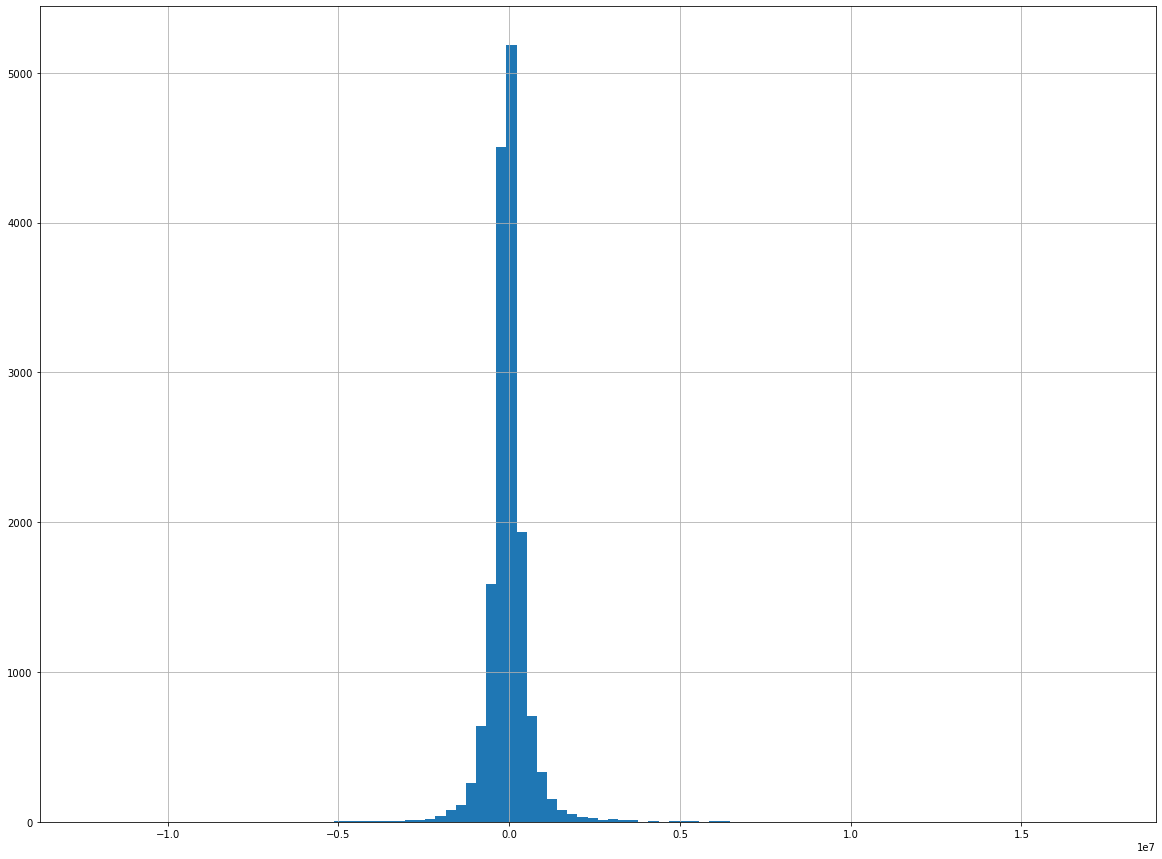

In [59]:
plt.figure(figsize = (20, 15))
plt.grid()
plt.hist(df_valid.error.values, bins = 100)
plt.show()

In [57]:
params = ['street_id', 'build_tech', 'floor', 'area','rooms', 'balcon', 'metro_dist', 'n_photos', 'kw1', 'kw2', 'mohth_from_begin',
          'price',  'pred', 'error', 'abs_error', 'fraction_error']

df_train[params].sort_values(by='fraction_error', ascending=False).head(10)

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,mohth_from_begin,price,pred,error,abs_error,fraction_error
36539,575,1.0,5,60,3,0,30.0,3,0,0,4,1373000,2.654178e+06,-1.356283e+06,1.356283e+06,1.044987
34279,28,1.0,5,60,3,0,30.0,4,0,0,4,2376000,4.359909e+06,-2.113880e+06,2.113880e+06,0.941163
10768,357,1.0,4,60,3,0,30.0,5,0,1,11,2708000,4.498941e+06,-2.162715e+06,2.162715e+06,0.925730
50299,254,1.0,5,60,3,0,30.0,3,0,1,7,3044000,5.276901e+06,-2.512812e+06,2.512812e+06,0.909092
92487,97,0.0,4,34,1,0,30.0,0,0,1,15,570000,8.911337e+05,-4.227693e+05,4.227693e+05,0.902650
67248,19,1.0,5,60,3,0,30.0,2,0,1,13,2152000,3.437461e+06,-1.626117e+06,1.626117e+06,0.897740
10253,100,0.0,2,34,1,0,25.0,1,0,1,10,654000,1.076722e+06,-5.053774e+05,5.053774e+05,0.884540
15265,390,1.0,3,60,3,0,10.0,3,0,1,11,4389000,7.100517e+06,-3.314070e+06,3.314070e+06,0.875245
49635,39,1.0,5,60,3,0,30.0,5,0,1,7,1871000,3.174430e+06,-1.475479e+06,1.475479e+06,0.868464
18647,406,1.0,5,60,3,0,10.0,3,0,0,12,6480000,1.021531e+07,-4.693842e+06,4.693842e+06,0.850108


Подбираю гиперпараметры модели

In [ ]:
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
space = {
        'n_estimators': hp.quniform('n_estimators', 5000, 15000, 1),
        'depth': hp.quniform("depth", 5, 9, 1),
        'learning_rate': hp.loguniform('learning_rate', -3.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 100, 300),
        'bagging_temperature': hp.uniform('bagging_temperature', 0.2, 1), 
       }
cur_loss = np.inf

In [ ]:
def objective(params):
    model = catboost.CatBoostRegressor(
                                       iterations= params['n_estimators'], 
                                       learning_rate = params['learning_rate'],
                                       depth = int(params['depth']),
                                       l2_leaf_reg = params['l2_leaf_reg'],
                                       bagging_temperature = params['bagging_temperature'],
                                       loss_function = 'MAE',
                                       use_best_model = True,
                                    #    task_type = 'GPU',
                                       eval_metric = 'MAE'
                                       )
    model.fit(train_pool, eval_set = valid_pool, verbose = False)
    y_pred = model.predict(valid_pool) 
    loss = mean_absolute_error(valid_pool.get_label(), y_pred)
    print(loss)


    return {'loss':loss, 'status': STATUS_OK }



best = hyperopt.fmin(fn = objective, 
                     space = space,
                     algo = tpe.suggest,
                     max_evals = 20,
                     verbose = True,
                     )


In [ ]:
print(best)

{'bagging_temperature': 0.4284125413656453, 'depth': 6.0, 'l2_leaf_reg': 198.82058063891878, 'learning_rate': 0.05555877573482939, 'n_estimators': 14393.0, 'rsm': 0.996676586540747}